In [7]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [8]:
rng = np.random.default_rng()

In [15]:
def simulate_dataset_custom(name, gene_values, cells=1000, rate=1, runs=1, tqdm_disable=True):

    # number of pairs
    gene_pairs = len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # count
    i = 0

    # for each sample
    for gene in tqdm.tqdm(gene_values, disable=tqdm_disable):
        for k in range(runs):

            # Set reaction rate parameters
            k_on_1 = gene
            k_on_2 = gene
            k_off_1 = 1 - gene
            k_off_2 = 1 - gene
            k_tx_1 = rate
            k_tx_2 = rate
            k_deg_1 = 1
            k_deg_2 = 1
            k_reg = 0

            # store parameters
            params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

            params = {
                'k_on_1': k_on_1,
                'k_on_2': k_on_2,
                'k_off_1': k_off_1,
                'k_off_2': k_off_2,
                'k_tx_1': k_tx_1,
                'k_tx_2': k_tx_2,
                'k_deg_1': k_deg_1,
                'k_deg_2': k_deg_2,
                'k_reg': k_reg
            }

            # simulate sample from model
            sample = simulation.gillespie_telegraph(params, cells)

            # store counts
            counts_df.iloc[i] = sample

            # increment
            i += 1

    # construct dataset object
    data = dataset.Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [16]:
# settings
gene_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 5
rate = 5

In [17]:
data = simulate_dataset_custom("data-indep", gene_values, runs=runs, rate=rate, tqdm_disable=False)

100%|██████████| 10/10 [02:20<00:00, 14.02s/it]


100%|██████████| 50/50 [00:01<00:00, 43.10it/s]


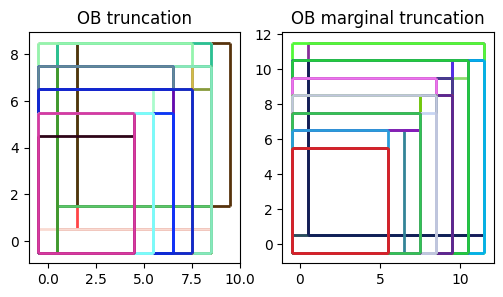

100%|██████████| 88/88 [00:00<00:00, 3398.26it/s]


In [18]:
# pre-process
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(tqdm_disable=False, display=True)

In [19]:
# BD prob
prob_BD = optimization.Optimization(
    data,
    ["marginal_probability", "marginal_CME", "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

# BD moment
momt_BD = optimization.Optimization(
    data,
    ["moment", "marginal_CME", "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 50/50 [00:00<00:00, 65.31it/s]


In [20]:
# size
size = len(gene_values)

# result arrays
prob_BD_array = np.zeros(size)
momt_BD_array = np.zeros(size)

# sample counter
i = 0

# for each sample
for j, _ in enumerate(gene_values):
    for k in range(runs):

        # get result
        if prob_BD.result_dict[i]['status'] == "INFEASIBLE":
            prob_BD_array[j] += 1 / runs
        if momt_BD.result_dict[i]['status'] == "INFEASIBLE":
            momt_BD_array[j] += 1 / runs

        # increment counter
        i += 1

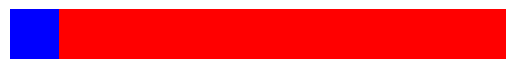

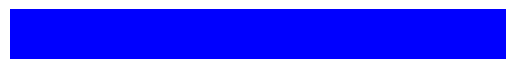

In [41]:
cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)
img_prob_BD = plt.imshow(prob_BD_array.reshape(1, -1), cmap=cmap)
plt.axis('off')
plt.show()
img_momt_BD = plt.imshow(momt_BD_array.reshape(1, -1), cmap=cmap)
plt.axis('off')
plt.show()